<a href="https://colab.research.google.com/github/sb2539/AI-study/blob/master/mlpmixergat(channels)osuleaf3channels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyts
!pip install einops
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 30.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 29.7 MB/s 
     |████████████████████████████████| 157 kB 66.0 MB/s 
     |████████████████████████████████| 181 kB 68.9 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 157 kB 64.0 MB/s 
     |████████████████████████████████| 156 kB 68.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=8aafa9b7060b900ab1998fdeb33b8d0a8a070f4154eaf0740ca4ca0e004a7a1b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pylab as plt
import numpy as np
import pandas as pd
from pyts.image import RecurrencePlot, GramianAngularField, MarkovTransitionField
from pyts.datasets import fetch_ucr_dataset, ucr_dataset_list
from PIL import Image
from skimage.transform import resize
import os
from torch.utils.tensorboard import SummaryWriter
from einops.layers.torch import Rearrange, Reduce
import copy
import wandb

In [4]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
wandb.login()

wandb: Currently logged in as: sb2539. Use `wandb login --relogin` to force relogin


True

# syntcontrol


In [6]:
wa = fetch_ucr_dataset('OSULeaf', use_cache=False, data_home = None, return_X_y=False)
wa_train = wa.data_train
wa_target_train = wa.target_train
wa_test = wa.data_test
wa_target_test = wa.target_test

In [ ]:
wa_test

In [ ]:
wa_target_val = wa_target_test[:100]
wa_val = wa_test[:100,:]

In [ ]:
wa_target_test

In [7]:
rp = RecurrencePlot(dimension = 3,time_delay=4)
wa_train_rp = rp.transform(wa_train)
wa_test_rp = rp.transform(wa_test)

In [8]:
gr_d = GramianAngularField(method='difference')
wa_train_gr_d = gr_d.transform(wa_train)
wa_test_gr_d = gr_d.transform(wa_test)
gr = GramianAngularField()
wa_train_gr = gr.transform(wa_train)
wa_test_gr = gr.transform(wa_test)

In [9]:
mk = MarkovTransitionField()
wa_train_mk = mk.transform(wa_train)
wa_test_mk = mk.transform(wa_test)

In [10]:
wa_train_rp = resize(wa_train_rp, ((200,96,96)))
wa_test_rp = resize(wa_test_rp, ((242,96,96)))
wa_train_gr = resize(wa_train_gr, ((200,96,96)))
wa_test_gr = resize(wa_test_gr, ((242,96,96)))
wa_train_gr_d = resize(wa_train_gr_d, ((200,96,96)))
wa_test_gr_d = resize(wa_test_gr_d, ((242,96,96)))
wa_train_mk = resize(wa_train_mk, ((200,96,96)))
wa_test_mk = resize(wa_test_mk, ((242,96,96)))

In [11]:
wa_train_all = np.stack([wa_train_rp, wa_train_gr, wa_train_gr_d, wa_train_mk], 1)
wa_test_all = np.stack([wa_test_rp, wa_test_gr, wa_test_gr_d, wa_test_mk], 1)

In [ ]:
wa_train_all = np.stack([wa_train_rp, wa_train_gr,wa_train_gr_d], 1)
wa_test_all = np.stack([wa_test_rp, wa_test_gr, wa_test_gr_d], 1)

In [13]:
train_data = CustomDataset(wa_train_all, wa_target_train)
trainloader = DataLoader(train_data, batch_size = 5, shuffle = True)
test_data = CustomDataset(wa_test_all, wa_target_test)
testloader = DataLoader(test_data, batch_size = 5, shuffle = False )

In [ ]:
val_data = CustomDataset(val_all,wa_target_val)
valloader = DataLoader(val_data, batch_size = 5, shuffle = False)

In [ ]:
wa_train_rp = resize(wa_train_rp, ((300,56,56)))
wa_test_rp = resize(wa_test_rp, ((300,56,56)))
wa_train_rp = wa_train_rp.reshape(300, 1, 56, 56)
wa_test_rp = wa_test_rp.reshape(300, 1, 56, 56)
train_data = CustomDataset(wa_train_rp, wa_target_train)
trainloader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_data = CustomDataset(wa_test_rp, wa_target_test)
testloader = DataLoader(test_data, batch_size = 10, shuffle = False )

# customdata

In [12]:
class CustomDataset(Dataset):
    def __init__(self, rpimage, target_image):
        self.x_data = torch.FloatTensor(rpimage)
        self.y_data = torch.LongTensor(target_image)
        self.y_data = self.y_data-1
    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# mlp

In [14]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [15]:
class MixerBlock(nn.Module):
    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.):
        super(MixerBlock, self).__init__()

        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'), #(n_samples, n_patches, dim) -> (n_samples, dim, n_patches)
            MLP(num_patch, token_dim, dropout),
            Rearrange('b d n -> b n d')  # 원상복구
        )

        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            MLP(dim, channel_dim, dropout),
        )

    def forward(self, x):
        x = x + self.token_mix(x)  # skip connection 부분
        x = x + self.channel_mix(x) # skip connection 부분
        return x

In [41]:
class AttentionLayer(nn.Module):
    def __init__(self, in_channels, num_patch, image_size, dropout, alpha, use_bias = False):
        super(AttentionLayer, self). __init__()
        self.n_features = in_channels  # 4
        self.num_nodes = in_channels   # 4
        self.dim = image_size    # 64 
        self.use_bias = use_bias
        lin_input_dim = num_patch    # 64
        a_input_dim = 2 * self.dim   # 128

        self.lin = nn.Linear(num_patch, self.dim) # (144,64)
        self.a = nn.Parameter(torch.empty((a_input_dim, 1))) #(64)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        if self.use_bias:
            self.bias = nn.Parameter(torch.empty(num_patch, num_patch))

        self.leakyrelu = nn.LeakyReLU(alpha)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        Wx = self.lin(x)  # (5, 4, 64)
        a_input = self._make_attention_input(Wx) #(5, 4, 4, 128)
        e = self.leakyrelu(torch.matmul(a_input, self.a)).squeeze(3) #(5, 4,4,1)
        if self.use_bias:
            e+=self.bias

        attention = torch.softmax(e, dim = 2)
        h = self.sigmoid(torch.matmul(attention, x)) # (5, 4, 4) * (5, 4, 64)
        return h # (5, 4, 64)
        
    def _make_attention_input(self, v):
        K = self.num_nodes
        blocks_repeating = v.repeat_interleave(K, dim = 1)
        blocks_alternating = v.repeat(1, K, 1)
        combined = torch.cat((blocks_repeating, blocks_alternating), dim = 2)

        return combined.view(v.size(0), K, K, 2 * self.dim)

In [17]:
tp = torch.rand(5, 64, 64, 64)
ta = torch.rand(64,64)

In [18]:
tre = torch.matmul(tp, ta)
tre.shape

torch.Size([5, 64, 64, 64])

In [42]:
class MLPMixer(nn.Module):
    def __init__(self, in_channels, dim, num_classes, patch_size, image_size, depth, token_dim, channel_dim, dropout = 0., alpha = 0.2):
        super(MLPMixer, self).__init__()
        self.dropout = dropout
        assert image_size % patch_size == 0 # 이미지 사이즈가 패치 사이즈로 나누어져야 함
        self.num_patch = (image_size // patch_size) **2 # num_patch = 64 , img_size = 64, patch_size = 8
        self.channel_gat = AttentionLayer(in_channels, self.num_patch, image_size, alpha)
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, patch_size, patch_size), # (in_channel = 4, out_channel=4, kernel = 8, stride =  8)
            Rearrange('b c h w -> b c (h w)') #(5, 4, 12, 12) -> (5, 4, 144)
        )                                     # 64 * 512 matrix 만들어짐
        self.lin = nn.Sequential(
            Rearrange('b c p -> b p c'),
            nn.Linear(in_channels ,dim)
        )
        self.mixer_blocks = nn.ModuleList([])
        for _ in range(depth):     # depth = 8 만큼 
            self.mixer_blocks.append(
                MixerBlock(dim, self.num_patch, token_dim, channel_dim, dropout) #(512, 64, 256, 2048 )
            )

        self.layer_norm = nn.LayerNorm(dim)
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x): # 입력 (5, 4, 64, 64)
        x = self.patch_embedding(x)  # (5, 3, 64) before (5, 64, 3)
        x = self.channel_gat(x) #(5, 4, 144)
        x = self.lin(x)
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x) # (1, 64, 512)
        x = self.layer_norm(x)
        x = x.mean(dim = 1) # global average pooling (1, 512)
        x = self.mlp_head(x) # (1, 5)
        return x

# weight & bias

In [18]:
PATH = "/gdrive/MyDrive/model/"
global best_acc 
best_acc = 0

In [19]:
def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

In [20]:
def train(model, trainloader, testloader, criterion, optimizer, config, wandb):
    global best_acc
    model.train()
    wandb.watch(model, criterion, log="all", log_freq=10)
    for epoch in range(config.epochs):
        cumu_loss = 0
        correct = 0
        val_correct = 0
        target_loss = 0
        for data in trainloader:
            input, target  = data

            output = model(input)
            loss = criterion(output, target)
            cumu_loss += loss.item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else :
            with torch.no_grad():
                for data in testloader:
                    input, target = data
                    output = model(input)
                    target_loss += criterion(output, target).item()
                    pred = output.max(1, keepdim=True)[1]
                    val_correct += pred.eq(target.view_as(pred)).sum().item()

        val_loss = target_loss / len(testloader)
        avg_loss = cumu_loss / len(trainloader)
        train_acc = 100. * correct / len(trainloader.dataset)
        val_acc = 100. * val_correct / len(testloader.dataset)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), PATH + 'osuleafgatchannel_mlp_state_dictonly_rp_gr_grd_mk.pt')
            print("saved")
        wandb.log({"train_loss": avg_loss, "train_acc":train_acc}, step=epoch)  
        print(f"TRAIN: EPOCH {epoch + 1:04d} / {config.epochs:04d} | Epoch LOSS {avg_loss:.4f} | Epoch ACC {train_acc:.4f} | Val Loss {val_loss:.4f} | Val_acc {val_acc:.4f}")

In [21]:
def test(model, loader, criterion, wandb):
    model.eval()

    with torch.no_grad():
        correct, target_loss = 0, 0
        for data in loader:
            input, target = data
            output = model(input)
            
            target_loss += criterion(output, target).item()
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    
    test_loss = target_loss / len(loader)
    test_acc = 100. * correct / len(loader.dataset)
    print(f"test: LOSS {test_loss:.4f} | Accuracy {test_acc:.4f} ")
    wandb.log({
        "test_acc": test_acc,
        "test_loss": test_loss})

In [48]:
sweep_config = {
    'name' : 'osu_rp_gr_grd-gat_channel-sweep',
    'method' : 'random',
    'metric' : {
        'name': 'test_acc',
        'goal': 'maximize'
    },
    'parameters':{
        'optimizer':{
            'values':['adam']
        },
        'dropout':{
            'values':[0.]
        },
        'learning_rate':{
            'distribution':'uniform',
            'min':0.0001,
            'max':0.001
        },
        'epochs':{
            'values': [50]
        },
        'hidden_size':{
            'values': [64, 128, 256, 512]
        },
        'patch_size':{
            'values': [4, 8, 16]
        },
        'number_of_layers':{
            'values':[4,8,16]
        },
        'token_dim':{
            'values':[32, 64, 128, 256, 512]
        },
        'channel_dim':{
            'values':[32, 64, 128, 256, 512]
        },
        'alpha':{
            'values':[0.2]
        }
    }
}

In [49]:
def run_sweeep(config=None):
    wandb.init(config=config, entity='sb2539')
    w_config = wandb.config
    criterion = nn.CrossEntropyLoss()
    in_channels = 3
    num_classes = 6
    resolution = 96
    model = MLPMixer(
        in_channels = in_channels,
        dim = w_config.hidden_size,
        num_classes = num_classes,
        patch_size = w_config.patch_size,
        image_size = resolution,
        depth = w_config.number_of_layers,
        token_dim = w_config.token_dim,
        channel_dim = w_config.channel_dim,
        dropout = w_config.dropout,
        alpha = w_config.alpha
    )
    optimizer = build_optimizer(model, w_config.optimizer, w_config.learning_rate)

    train(model, trainloader, testloader, criterion, optimizer,  w_config, wandb)
    test(model, testloader, criterion, wandb)

In [47]:
sweep_id = wandb.sweep(sweep_config, project="osuleaf_mlp_gat_channel_rp_gr_grd", entity='sb2539')
wandb.agent(sweep_id, run_sweeep, count=100)

Create sweep with ID: irqvhxia
Sweep URL: https://wandb.ai/sb2539/osuleaf_mlp_gat_channel_rp_gr_grd_mk/sweeps/irqvhxia


wandb: Agent Starting Run: sdjfnnai with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 256
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0006750402005868284
wandb: 	number_of_layers: 4
wandb: 	optimizer: adam
wandb: 	patch_size: 16
wandb: 	token_dim: 256
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7953 | Epoch ACC 23.5000 | Val Loss 1.7532 | Val_acc 18.1818
saved
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.5994 | Epoch ACC 37.5000 | Val Loss 1.6607 | Val_acc 27.6860
saved
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.3360 | Epoch ACC 41.5000 | Val Loss 1.4475 | Val_acc 31.8182
saved
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.2377 | Epoch ACC 41.5000 | Val Loss 1.4377 | Val_acc 41.7355
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.4578 | Epoch ACC 39.5000 | Val Loss 1.3945 | Val_acc 30.9917
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.3104 | Epoch ACC 39.0000 | Val Loss 1.4054 | Val_acc 35.9504
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.2475 | Epoch ACC 40.0000 | Val Loss 1.3950 | Val_acc 33.4711
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.2076 | Epoch ACC 44.5000 | Val Loss 1.4671 | Val_acc 35.1240
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.2826 | Epoch ACC 44.0000 | Val Loss 1.4341 | Val_acc 34.2975
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.2771 | Epoch ACC 41.5000 | Val Lo

test_acc,▁
test_loss,▁
train_acc,▁▂▃▃▂▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▇▆▇▇▇▇█▇▇▇▇▇▇▇▇████
train_loss,█▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▂▃▂▂▂▂▁▂▂▂▂▂▂▃▂▁▁▁▁
test_acc,52.89256
test_loss,2.4909
train_acc,100.0
train_loss,0.00969


wandb: Agent Starting Run: goq8w3gx with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 64
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0007488398901811529
wandb: 	number_of_layers: 4
wandb: 	optimizer: sgd
wandb: 	patch_size: 8
wandb: 	token_dim: 64
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7839 | Epoch ACC 21.5000 | Val Loss 1.8496 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7555 | Epoch ACC 27.5000 | Val Loss 1.7651 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.6915 | Epoch ACC 29.5000 | Val Loss 1.6644 | Val_acc 32.2314
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.6389 | Epoch ACC 31.0000 | Val Loss 1.6080 | Val_acc 28.5124
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.4315 | Epoch ACC 35.5000 | Val Loss 1.4683 | Val_acc 31.4050
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.2970 | Epoch ACC 42.0000 | Val Loss 1.8855 | Val_acc 19.0083
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.5730 | Epoch ACC 36.0000 | Val Loss 1.5644 | Val_acc 32.6446
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.3623 | Epoch ACC 42.5000 | Val Loss 1.4502 | Val_acc 30.5785
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.2804 | Epoch ACC 41.5000 | Val Loss 1.4521 | Val_acc 35.9504
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.2561 | Epoch ACC 38.0000 | Val Loss 1.4363 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▂▂▂▃▃▃▃▃▃▃▃▂▃▃▃▃▃▄▄▄▄▄▅▃▃▄▄▆▆▅▇▇▇▇▇███▆
train_loss,███▇▆▇▆▅▅▅▅▅▇▅▅▅▅▅▅▅▄▄▄▄▆▅▄▄▄▄▄▃▃▂▂▂▁▁▁▅
test_acc,21.4876
test_loss,1.83754
train_acc,64.5
train_loss,1.14972


wandb: Agent Starting Run: 4j350vft with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 128
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0005733429205254941
wandb: 	number_of_layers: 4
wandb: 	optimizer: adam
wandb: 	patch_size: 4
wandb: 	token_dim: 128
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7798 | Epoch ACC 22.0000 | Val Loss 1.7834 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7592 | Epoch ACC 26.5000 | Val Loss 1.7742 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7456 | Epoch ACC 26.5000 | Val Loss 1.7883 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7513 | Epoch ACC 26.5000 | Val Loss 1.8016 | Val_acc 18.1818
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.7640 | Epoch ACC 26.5000 | Val Loss 1.7852 | Val_acc 18.1818
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.7440 | Epoch ACC 26.5000 | Val Loss 1.7800 | Val_acc 18.1818
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.7453 | Epoch ACC 26.5000 | Val Loss 1.7898 | Val_acc 18.1818
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.7506 | Epoch ACC 26.5000 | Val Loss 1.7925 | Val_acc 18.1818
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.7497 | Epoch ACC 26.5000 | Val Loss 1.7837 | Val_acc 18.1818
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.7420 | Epoch ACC 26.5000 | Val Loss 1.7905 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▄▅▆▆▇▇████████▇████
train_loss,█████████████████▇▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁
test_acc,49.17355
test_loss,2.67632
train_acc,100.0
train_loss,0.00385


wandb: Agent Starting Run: 4ezutpao with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 256
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0008751483269980246
wandb: 	number_of_layers: 8
wandb: 	optimizer: adam
wandb: 	patch_size: 8
wandb: 	token_dim: 32
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.8289 | Epoch ACC 22.5000 | Val Loss 1.8128 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7525 | Epoch ACC 26.5000 | Val Loss 1.7988 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7463 | Epoch ACC 26.5000 | Val Loss 1.7860 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7483 | Epoch ACC 26.5000 | Val Loss 1.7826 | Val_acc 18.1818
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.7458 | Epoch ACC 26.5000 | Val Loss 1.7818 | Val_acc 18.1818
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.7192 | Epoch ACC 26.5000 | Val Loss 1.6628 | Val_acc 18.1818
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.4640 | Epoch ACC 38.0000 | Val Loss 1.5352 | Val_acc 32.2314
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.4359 | Epoch ACC 32.5000 | Val Loss 1.5953 | Val_acc 28.5124
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.3631 | Epoch ACC 42.0000 | Val Loss 1.4110 | Val_acc 31.4050
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.1809 | Epoch ACC 40.5000 | Val Loss 1.3335 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▁▁▁▂▂▃▃▃▃▃▃▄▅▅▅▆▆▆▅▆▆▇▇▇█████▇▇▆▆▆▇███
train_loss,█████▇▆▆▅▅▅▅▅▄▄▄▄▃▃▃▄▃▃▃▂▂▂▁▁▁▁▂▂▄▄▃▂▁▂▁
test_acc,55.3719
test_loss,2.04636
train_acc,99.0
train_loss,0.03645


wandb: Agent Starting Run: vdvuya2b with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 32
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0003277522035784304
wandb: 	number_of_layers: 16
wandb: 	optimizer: sgd
wandb: 	patch_size: 8
wandb: 	token_dim: 32
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7755 | Epoch ACC 23.5000 | Val Loss 1.7869 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7561 | Epoch ACC 26.5000 | Val Loss 1.8033 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7512 | Epoch ACC 26.5000 | Val Loss 1.7865 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7569 | Epoch ACC 23.0000 | Val Loss 1.8053 | Val_acc 18.1818
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.7683 | Epoch ACC 24.0000 | Val Loss 1.7855 | Val_acc 18.1818
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.7548 | Epoch ACC 26.5000 | Val Loss 1.7903 | Val_acc 18.1818
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.7634 | Epoch ACC 26.5000 | Val Loss 1.8013 | Val_acc 18.1818
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.7605 | Epoch ACC 26.5000 | Val Loss 1.7790 | Val_acc 18.1818
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.7514 | Epoch ACC 20.5000 | Val Loss 1.8011 | Val_acc 18.1818
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.7508 | Epoch ACC 26.5000 | Val Loss 1.8051 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▂▂▂▂▂▂▂▁▂▂▂▂▂▂▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█▇▇▇
train_loss,████████████▇▇▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▂
test_acc,44.21488
test_loss,1.33566
train_acc,50.5
train_loss,1.0827


wandb: Agent Starting Run: ckjdopre with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 32
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0003548231333300887
wandb: 	number_of_layers: 8
wandb: 	optimizer: adam
wandb: 	patch_size: 4
wandb: 	token_dim: 256
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7694 | Epoch ACC 24.5000 | Val Loss 1.7902 | Val_acc 30.1653
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.5725 | Epoch ACC 38.0000 | Val Loss 1.5254 | Val_acc 30.1653
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.3344 | Epoch ACC 41.0000 | Val Loss 1.4395 | Val_acc 37.1901
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.1535 | Epoch ACC 51.5000 | Val Loss 1.3725 | Val_acc 37.6033
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.0037 | Epoch ACC 53.5000 | Val Loss 1.2775 | Val_acc 44.2149
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 0.8783 | Epoch ACC 63.5000 | Val Loss 1.2778 | Val_acc 49.1736
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 0.8305 | Epoch ACC 68.0000 | Val Loss 1.2458 | Val_acc 48.7603
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 0.6498 | Epoch ACC 76.0000 | Val Loss 1.3360 | Val_acc 50.4132
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 0.5930 | Epoch ACC 75.0000 | Val Loss 1.3383 | Val_acc 45.8678
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 0.5316 | Epoch ACC 78.0000 | Val Loss 1.3157 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▅▅▆▆▆▇▇▇▇▇██▇███████████████████████
train_loss,█▇▆▆▄▄▄▃▃▃▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,55.78512
test_loss,2.49394
train_acc,100.0
train_loss,0.00329


wandb: Agent Starting Run: ykhnfrrm with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 256
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.00030468372939782435
wandb: 	number_of_layers: 4
wandb: 	optimizer: adam
wandb: 	patch_size: 4
wandb: 	token_dim: 32
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7927 | Epoch ACC 24.0000 | Val Loss 1.7922 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7521 | Epoch ACC 25.0000 | Val Loss 1.7874 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7468 | Epoch ACC 26.5000 | Val Loss 1.7817 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7448 | Epoch ACC 26.5000 | Val Loss 1.7949 | Val_acc 18.1818
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.7401 | Epoch ACC 26.5000 | Val Loss 1.8095 | Val_acc 18.1818
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.7499 | Epoch ACC 26.5000 | Val Loss 1.7868 | Val_acc 18.1818
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.7427 | Epoch ACC 26.5000 | Val Loss 1.7942 | Val_acc 18.1818
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.7130 | Epoch ACC 27.5000 | Val Loss 1.7064 | Val_acc 34.2975
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.5000 | Epoch ACC 41.0000 | Val Loss 1.8569 | Val_acc 26.4463
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.3017 | Epoch ACC 47.5000 | Val Loss 1.3377 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▁▁▁▁▁▃▃▄▄▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇█████████████
train_loss,███████▇▆▅▅▄▄▃▃▃▃▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▂▁▁▁▁
test_acc,50.82645
test_loss,2.59063
train_acc,99.5
train_loss,0.02177


wandb: Agent Starting Run: qp3t31vw with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 256
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.000921892622560296
wandb: 	number_of_layers: 4
wandb: 	optimizer: sgd
wandb: 	patch_size: 8
wandb: 	token_dim: 64
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.8441 | Epoch ACC 16.0000 | Val Loss 1.7894 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.8074 | Epoch ACC 21.0000 | Val Loss 1.7897 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7852 | Epoch ACC 24.5000 | Val Loss 1.7897 | Val_acc 19.0083
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7398 | Epoch ACC 28.0000 | Val Loss 1.7195 | Val_acc 25.6198
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.6144 | Epoch ACC 29.0000 | Val Loss 1.5315 | Val_acc 28.0992
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.7313 | Epoch ACC 28.5000 | Val Loss 1.7979 | Val_acc 18.1818
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.7599 | Epoch ACC 23.5000 | Val Loss 1.8402 | Val_acc 18.1818
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.7261 | Epoch ACC 25.5000 | Val Loss 1.7226 | Val_acc 33.0579
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.6789 | Epoch ACC 31.5000 | Val Loss 1.6951 | Val_acc 21.9008
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.6151 | Epoch ACC 35.0000 | Val Loss 1.6544 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▇▇▇▇▇███████████████
train_loss,███████▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,48.34711
test_loss,2.58749
train_acc,100.0
train_loss,0.00381


wandb: Agent Starting Run: hn41u6i9 with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 32
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0005268641042854052
wandb: 	number_of_layers: 8
wandb: 	optimizer: sgd
wandb: 	patch_size: 8
wandb: 	token_dim: 32
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7900 | Epoch ACC 21.5000 | Val Loss 1.8107 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7646 | Epoch ACC 26.5000 | Val Loss 1.8132 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7616 | Epoch ACC 26.5000 | Val Loss 1.7855 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7659 | Epoch ACC 22.5000 | Val Loss 1.8263 | Val_acc 18.1818
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.7601 | Epoch ACC 23.0000 | Val Loss 1.7823 | Val_acc 18.1818
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.7498 | Epoch ACC 26.5000 | Val Loss 1.7939 | Val_acc 18.1818
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.7406 | Epoch ACC 26.5000 | Val Loss 1.7945 | Val_acc 18.1818
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.7373 | Epoch ACC 26.5000 | Val Loss 1.8075 | Val_acc 18.1818
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.7336 | Epoch ACC 26.5000 | Val Loss 1.7822 | Val_acc 18.1818
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.7337 | Epoch ACC 26.5000 | Val Loss 1.8025 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇████
train_loss,████████████▇▇▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁
test_acc,53.30579
test_loss,1.86224
train_acc,99.0
train_loss,0.09871


wandb: Agent Starting Run: 0hopg8zg with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 64
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0007188970019724419
wandb: 	number_of_layers: 16
wandb: 	optimizer: sgd
wandb: 	patch_size: 4
wandb: 	token_dim: 32
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7793 | Epoch ACC 22.5000 | Val Loss 1.8016 | Val_acc 13.2231
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7703 | Epoch ACC 22.5000 | Val Loss 1.8173 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7637 | Epoch ACC 23.5000 | Val Loss 1.8096 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7467 | Epoch ACC 24.5000 | Val Loss 1.7975 | Val_acc 18.1818
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.7611 | Epoch ACC 26.5000 | Val Loss 1.7798 | Val_acc 18.1818
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.7456 | Epoch ACC 26.5000 | Val Loss 1.8098 | Val_acc 18.1818
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.7456 | Epoch ACC 22.5000 | Val Loss 1.7974 | Val_acc 18.1818
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.7545 | Epoch ACC 21.5000 | Val Loss 1.8301 | Val_acc 18.1818
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.7443 | Epoch ACC 26.5000 | Val Loss 1.7847 | Val_acc 18.1818
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.7382 | Epoch ACC 24.0000 | Val Loss 1.8148 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▁▁▁▁▁▁▁▂▁▁▃▃▃▃▃▄▄▅▄▅▅▅▆▆▆▇▇▇▇▇▇█▇▇▇███
train_loss,████████████▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁
test_acc,48.34711
test_loss,2.15771
train_acc,98.5
train_loss,0.06671


wandb: Agent Starting Run: jbqgn45z with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 256
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0007033957519279656
wandb: 	number_of_layers: 16
wandb: 	optimizer: adam
wandb: 	patch_size: 8
wandb: 	token_dim: 128
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.8433 | Epoch ACC 22.5000 | Val Loss 1.7834 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7614 | Epoch ACC 22.5000 | Val Loss 1.7612 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7554 | Epoch ACC 23.0000 | Val Loss 1.7888 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.6431 | Epoch ACC 28.0000 | Val Loss 1.5549 | Val_acc 30.5785
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.3193 | Epoch ACC 42.0000 | Val Loss 1.5441 | Val_acc 26.4463
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.2322 | Epoch ACC 45.0000 | Val Loss 1.3800 | Val_acc 33.8843
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.2186 | Epoch ACC 42.5000 | Val Loss 1.3370 | Val_acc 34.7107
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.0911 | Epoch ACC 50.5000 | Val Loss 1.3321 | Val_acc 33.4711
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.0477 | Epoch ACC 51.0000 | Val Loss 1.4073 | Val_acc 36.7769
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.0535 | Epoch ACC 47.0000 | Val Loss 1.4603 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▁▁▃▃▄▄▄▄▅▅▆▆▆▆▆▇▇▇████▇███████████████
train_loss,███▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,53.71901
test_loss,2.98365
train_acc,100.0
train_loss,0.00181


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 90lon9p7 with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 64
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0005571826342387707
wandb: 	number_of_layers: 16
wandb: 	optimizer: adam
wandb: 	patch_size: 8
wandb: 	token_dim: 64
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7869 | Epoch ACC 25.0000 | Val Loss 1.7844 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7451 | Epoch ACC 26.5000 | Val Loss 1.7510 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.4994 | Epoch ACC 37.5000 | Val Loss 1.3561 | Val_acc 36.3636
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.2623 | Epoch ACC 42.0000 | Val Loss 1.3908 | Val_acc 37.1901
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.1788 | Epoch ACC 46.5000 | Val Loss 1.2860 | Val_acc 36.3636
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.0671 | Epoch ACC 49.0000 | Val Loss 1.2998 | Val_acc 41.3223
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 0.9216 | Epoch ACC 58.5000 | Val Loss 1.5021 | Val_acc 38.0165
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.0161 | Epoch ACC 55.0000 | Val Loss 1.3666 | Val_acc 42.9752
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 0.8344 | Epoch ACC 63.0000 | Val Loss 1.2961 | Val_acc 40.0826
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 0.8323 | Epoch ACC 58.5000 | Val Loss 1.5434 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▂▃▃▄▄▅▅▅▅▆▇▇▇▇▇█▇▇████████████████████
train_loss,██▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,53.71901
test_loss,2.47096
train_acc,100.0
train_loss,0.00256


wandb: Agent Starting Run: celrvruw with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 64
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0008486086203016983
wandb: 	number_of_layers: 16
wandb: 	optimizer: adam
wandb: 	patch_size: 16
wandb: 	token_dim: 128
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.8009 | Epoch ACC 19.0000 | Val Loss 1.8076 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7623 | Epoch ACC 26.5000 | Val Loss 1.7869 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7448 | Epoch ACC 26.5000 | Val Loss 1.7958 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7464 | Epoch ACC 26.5000 | Val Loss 1.7933 | Val_acc 18.1818
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.6809 | Epoch ACC 29.0000 | Val Loss 1.6970 | Val_acc 26.4463
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.5135 | Epoch ACC 33.0000 | Val Loss 2.0568 | Val_acc 16.5289
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.5413 | Epoch ACC 35.0000 | Val Loss 1.6228 | Val_acc 26.8595
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.3986 | Epoch ACC 39.5000 | Val Loss 1.6049 | Val_acc 32.6446
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.3070 | Epoch ACC 41.5000 | Val Loss 1.4804 | Val_acc 38.0165
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.3863 | Epoch ACC 47.5000 | Val Loss 1.4808 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▂▂▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▆▅▆▇▇▇▇████▇▇██▇▇██
train_loss,████▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▃▄▃▂▂▂▃▂▁▁▂▃▂▁▁▂▂▁▁
test_acc,47.10744
test_loss,1.91389
train_acc,94.0
train_loss,0.21719


wandb: Agent Starting Run: p27j6qv0 with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 256
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0005082197751402019
wandb: 	number_of_layers: 4
wandb: 	optimizer: sgd
wandb: 	patch_size: 16
wandb: 	token_dim: 32
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.7994 | Epoch ACC 19.5000 | Val Loss 1.7813 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7693 | Epoch ACC 23.0000 | Val Loss 1.8243 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7503 | Epoch ACC 23.0000 | Val Loss 1.7806 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7574 | Epoch ACC 26.5000 | Val Loss 1.7738 | Val_acc 19.0083
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.7520 | Epoch ACC 24.0000 | Val Loss 1.7737 | Val_acc 18.1818
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.7268 | Epoch ACC 28.0000 | Val Loss 1.7806 | Val_acc 18.5950
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.6729 | Epoch ACC 31.5000 | Val Loss 1.7284 | Val_acc 24.7934
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.5598 | Epoch ACC 39.5000 | Val Loss 1.6134 | Val_acc 29.7521
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.3954 | Epoch ACC 37.5000 | Val Loss 1.5539 | Val_acc 32.2314
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.2802 | Epoch ACC 45.0000 | Val Loss 1.4594 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▄▅▆▆▆▇▇█▇▇▇▆▇▇██
train_loss,█████▇▇▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▂▂▆▄▃▃▃▂▂▂▂▃▂▄▂▂▁▁
test_acc,45.45455
test_loss,1.66446
train_acc,87.0
train_loss,0.39435


wandb: Agent Starting Run: lo2j3e7m with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 128
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0008970445275470471
wandb: 	number_of_layers: 16
wandb: 	optimizer: adam
wandb: 	patch_size: 16
wandb: 	token_dim: 128
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0050 | Epoch LOSS 1.8275 | Epoch ACC 18.0000 | Val Loss 1.7709 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0050 | Epoch LOSS 1.7553 | Epoch ACC 26.5000 | Val Loss 1.7735 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0050 | Epoch LOSS 1.7541 | Epoch ACC 22.5000 | Val Loss 1.8060 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0050 | Epoch LOSS 1.7538 | Epoch ACC 26.5000 | Val Loss 1.7899 | Val_acc 18.1818
TRAIN: EPOCH 0005 / 0050 | Epoch LOSS 1.7511 | Epoch ACC 26.5000 | Val Loss 1.7901 | Val_acc 18.1818
TRAIN: EPOCH 0006 / 0050 | Epoch LOSS 1.7451 | Epoch ACC 26.5000 | Val Loss 1.7791 | Val_acc 18.1818
TRAIN: EPOCH 0007 / 0050 | Epoch LOSS 1.6136 | Epoch ACC 35.5000 | Val Loss 1.6400 | Val_acc 29.3388
TRAIN: EPOCH 0008 / 0050 | Epoch LOSS 1.5942 | Epoch ACC 37.5000 | Val Loss 1.6736 | Val_acc 27.2727
TRAIN: EPOCH 0009 / 0050 | Epoch LOSS 1.4086 | Epoch ACC 41.0000 | Val Loss 1.5180 | Val_acc 29.3388
TRAIN: EPOCH 0010 / 0050 | Epoch LOSS 1.2601 | Epoch ACC 44.5000 | Val Loss 1.4125 | Val_ac

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
if __name__ == "__main__":
    from torchsummary import summary
    import pdb
 
    # base_model_param0.0009                        
    in_channels = 3                        
    hidden_size = 64                    
    num_classes = 6                        
    patch_size = 4                         
    resolution = 64                            
    number_of_layers = 4                    
    token_dim = 64                         
    channel_dim = 256                  
    dropout = 0
    alpha = 0.2                                         

    model = MLPMixer(
        in_channels = in_channels,
        dim = hidden_size,
        num_classes = num_classes,
        patch_size = patch_size,
        image_size = resolution,
        depth = number_of_layers,
        token_dim = token_dim,
        channel_dim = channel_dim,
        dropout = dropout,
        alpha = alpha
    )
    
    summary(model, (3,64,64), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
         Rearrange-2              [-1, 256, 64]               0
            Linear-3              [-1, 256, 64]           4,160
         LeakyReLU-4          [-1, 256, 256, 1]               0
           Sigmoid-5              [-1, 256, 64]               0
    AttentionLayer-6              [-1, 256, 64]               0
         LayerNorm-7              [-1, 256, 64]             128
         Rearrange-8              [-1, 64, 256]               0
            Linear-9               [-1, 64, 64]          16,448
             GELU-10               [-1, 64, 64]               0
          Dropout-11               [-1, 64, 64]               0
           Linear-12              [-1, 64, 256]          16,640
          Dropout-13              [-1, 64, 256]               0
              MLP-14              [-1, 

In [ ]:
if __name__ == "__main__":
    from torchsummary import summary
    import pdb
        
    # base_model_param0.0009                        
    in_channels = 3                        
    hidden_size = 64                    
    num_classes = 6                        
    patch_size = 4                         
    resolution = 64                            
    number_of_layers = 4                    
    token_dim = 16                         
    channel_dim = 256                  
    dropout = 0.3
    alpha = 0.2                                                #0          0.1

    model = MLPMixer(
        in_channels = in_channels,
        dim = hidden_size,
        num_classes = num_classes,
        patch_size = patch_size,
        image_size = resolution,
        depth = number_of_layers,
        token_dim = token_dim,
        channel_dim = channel_dim,
        dropout = dropout
    )

PATH = "/gdrive/MyDrive/model/"
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.0009)
#scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch:0.95**epoch,last_epoch = -1, verbose = False)
loss_list = []
iter = []
train_accuracy = []
validation_loss = []
validation_acc = []    

model.train()
epochs = 30
for epoch in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0
    correct = 0.0
    val_correct = 0.0
    total = 0.0
    val_total = 0
    for data in trainloader:
        input,target = data
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(output.data, 1)
        correct += preds.eq(target).sum().item()
        running_loss += loss.item()
    
        
    else:
        with torch.no_grad():
            for data in testloader:
                val_input, val_target = data
                val_outputs = model(val_input)
                val_loss = criterion(val_outputs, val_target)
                
                _, val_pred = torch.max(val_outputs, 1)
                val_running_loss  += val_loss.item()
                val_correct += val_pred.eq(val_target).sum().item()
        

    training_loss = running_loss/len(trainloader)
    val_loss = val_running_loss/len(testloader)
    train_acc = 100*correct/len(trainloader.dataset)
    val_acc = 100*val_correct/len(testloader.dataset)
    if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), PATH + 'osuleaf_mlp_state_dictonly_rp_gr_gr_d.pt')
            print("saved")
    print("=============================================================================================================================================================")
    print(f"TRAIN: EPOCH {epoch + 1:04d} / {epochs:04d} | Epoch LOSS {training_loss:.4f} | Epoch ACC {train_acc:.4f} | Val Loss {val_loss:.4f} | Val_acc {val_acc:.4f}")
    cost = running_loss/6
    loss_list.append(training_loss)
    train_accuracy.append(train_acc)
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    running_loss = 0.0
print('finish')

KeyboardInterrupt: ignored

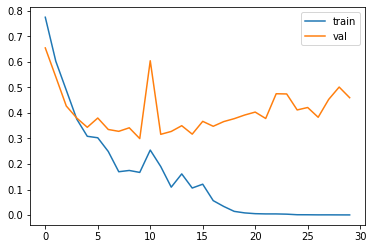

In [ ]:
plt.plot(loss_list, label='trainloss')
plt.plot(validation_loss, label='val_loss')
plt.legend(['train', 'val'])
plt.show()

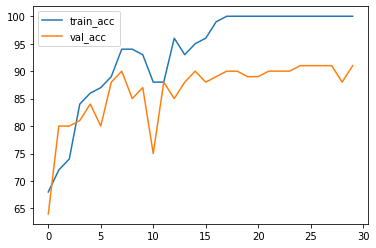

In [ ]:
plt.plot(train_accuracy, label='trainaccuracy')
plt.plot(validation_acc, label='val_acc')
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [ ]:
#model = torch.load(PATH + 'mlp.pt')
model.load_state_dict(copy.deepcopy(torch.load(PATH + 'fish_mlp_state_dict2.pt')))


<All keys matched successfully>

In [ ]:
model.load_state_dict(copy.deepcopy(torch.load(PATH + 'osuleafgat_mlp_state_dictonly_rp_gr_grd.pt')))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0
accuracy = []
iter_acc = []
test_loss = []
b=0
model.eval()
with torch.no_grad():
    for data in testloader :
        b+=1
        images, labels = data
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        iter_acc.append(b)
        cost = 100*correct/total
        accuracy.append(cost)
        
    test_loss.append(loss)
    error_rate = 1-(correct/total)
    test_acc = 100. * correct / len(testloader.dataset)
print('accuracy of testimages: %d %%' %(100*correct/total))
print('error rate : ', format(error_rate, ".3f"))
print(f"Val_acc {test_acc:.4f}")



accuracy of testimages: 67 %
error rate :  0.326
Val_acc 67.3554


In [ ]:
val_correct = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        val_input, val_target = data
        val_outputs = model(val_input)
        val_loss = criterion(val_outputs, val_target)
        _, val_pred = torch.max(val_outputs, 1)
        val_correct += val_pred.eq(val_target).sum().item()

    val_acc = 100. * val_correct/len(testloader.dataset)
    error_rate = 1-(val_correct/len(testloader.dataset))
print("=============================================================")
print(f"test acc {val_acc:.4f} | error rate {error_rate:.4f}")

test acc 59.3333 | error rate 0.4067


In [ ]:
torch.save(model.state_dict(), PATH + 'olive86_mlp_state_dict.pt')